In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


## USing PYTORCH

In [ ]:
PATH= "/content/dataset/Train/"

In [ ]:

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

## Transforming the data:

In [ ]:
data_transforms = {
    'Train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'Test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = "/content/gdrive/MyDrive/Intern DL/dataset"
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['Train']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['Train']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['Train']}
class_names = image_datasets['Train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
len(image_datasets['Train'])

850

## Splitting the data into train and validation

In [ ]:
## validation split
from torch.utils.data.sampler import SubsetRandomSampler

batch_size = 16
validation_split = .1
shuffle_dataset = True
random_seed= 42

dataset_size = len(dataloaders['Train'].dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(image_datasets['Train'], batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(image_datasets['Train'], batch_size=batch_size,
                                                sampler=valid_sampler)

In [ ]:
dataset_sizes= {
    'train': len(train_indices),
    'val' :len(valid_sampler)
}

In [ ]:
len(train_indices)

765

In [ ]:
75*16

1200

In [ ]:
len(train_loader.sampler)

765

## Data grid

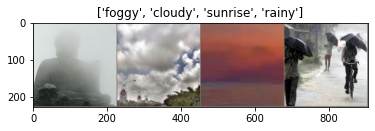

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['Train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Function to Train model

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloaders=train_loader
            else:
                model.eval()   # Set model to evaluate mode
                dataloaders= validation_loader

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## Model Setup 

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

## Training Model:

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=5)

Epoch 0/4
----------
train Loss: 0.1411 Acc: 0.9569
val Loss: 0.1891 Acc: 0.9294

Epoch 1/4
----------
train Loss: 0.1490 Acc: 0.9477
val Loss: 0.1550 Acc: 0.9529

Epoch 2/4
----------
train Loss: 0.1357 Acc: 0.9621
val Loss: 0.0915 Acc: 0.9765

Epoch 3/4
----------
train Loss: 0.1303 Acc: 0.9595
val Loss: 0.2026 Acc: 0.9294

Epoch 4/4
----------
train Loss: 0.1067 Acc: 0.9699
val Loss: 0.1566 Acc: 0.9529

Training complete in 0m 47s
Best val Acc: 0.976471


## Saving Model

In [ ]:
PATH= '/content/gdrive/MyDrive/Intern DL/model_internship.pth'
torch.save(model_ft.state_dict(), PATH)

In [ ]:
# putting model to cpu 
model_cpu= model_ft.to("cpu")

## Testing Model on Test images

In [1]:
data_dir = "/content/gdrive/MyDrive/Intern DL/dataset/Test/"

import glob 
import cv2


### Converting image to tensor

In [ ]:
from PIL import Image
from io import BytesIO
import os
from torchvision import transforms


img = Image.open("/content/gdrive/MyDrive/Intern DL/dataset/Test/Cloud_4.jpg")

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )])

img_t = preprocess(img)
print(img_t.size())
batch_t = torch.unsqueeze(img_t, 0).to("cpu")
print(batch_t.size())

torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])


### Sample prediction

In [ ]:
out= model_cpu(batch_t)
_, index = torch.max(out, 1)
class_names[index]

'cloudy'

In [ ]:
import glob 
import cv2

image_list= []


preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )])


for name in glob.glob("/content/gdrive/MyDrive/Intern DL/dataset/Test/*"):
    image_list.append(name) #appending filename in a list
 


### Predictions

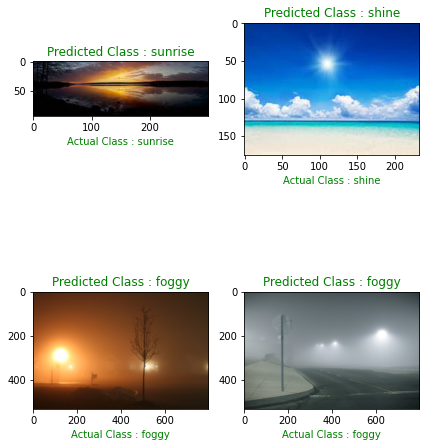

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random

def predict_(img):
    img_t = preprocess(img)
    batch_t = torch.unsqueeze(img_t, 0).to("cuda")
    out= model_ft(batch_t)
    _, index = torch.max(out, 1)
    predicted= class_names[index]
    return predicted

shuffled_list = random.sample(image_list, len(image_list))

# Took help from :
## https://stackoverflow.com/questions/46615554/how-to-display-multiple-images-in-one-figure-correctly/46616645
# settings
h, w = 10, 10        # for raster image
nrows, ncols = 2, 2  # array of sub-plots
figsize = [6, 8]     # figure size, inches

# create figure (fig), and array of axes (ax)
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)

for i, axi in enumerate(ax.flat):
    # i runs from 0 to (nrows*ncols-1)
    # axi is equivalent with ax[rowid][colid]
    #print(i)
    #print(shuffled_list[i])
    img = shuffled_list[i]
    img = Image.open(img).convert('RGB')
    output= predict_(img)
    axi.imshow(img)
    #to extract actual class name from file name
    actual_class=shuffled_list[i].split('/')[-1].split('_')[0]

    
    if actual_class== 'Cloud':
        actual_class='cloudy'
    if actual_class== 'rain':
        actual_class='rainy'

    if output == actual_class:
        axi.set_title(f"Predicted Class : {output}", color="green")
        axi.set_xlabel(f'Actual Class : {actual_class}',color="green")

    else:
        axi.set_title(f"Predicted Class : {output}", color="red")
        axi.set_xlabel(f'Actual Class : {actual_class}',color="red")

plt.tight_layout(True)
plt.show()